In [37]:
from loading_data import queryDB
import pandas as pd

In [38]:
import json
import numpy as np
import copy
import os

config_path = 'config.json'

with open(config_path) as config_buffer:
   config = json.loads(config_buffer.read())

model_path = config['model_weights']
num_concepts = len(config['conceptids'])
class_map_file = config['class_map']
concepts = config['conceptids']
classmap = pd.read_csv(class_map_file, header=None).to_dict()[0]

In [171]:
counts = queryDB('''
    select videoid, count(*) as total, 
        sum(case when conceptid=1629 then 1 else 0 end) As count1629, 
        sum(case when conceptid=1210 then 1 else 0 end) As count1210, 
        sum(case when conceptid=236 then 1 else 0 end) As count236, 
        sum(case when conceptid=383 then 1 else 0 end) As count383, 
        sum(case when conceptid=1133 then 1 else 0 end) As count1133 
    from annotations where userid != 17 and conceptid in (1629, 1210, 236, 383, 1133)
    group by videoid 
    order by total desc;
       ''')

counts.head(20)

,videoid,total,count1629,count1210,count236,count383,count1133
0,37,3916,0,4,2885,1024,3
1,39,2186,0,0,1077,1108,1
2,38,1032,0,0,660,371,1
3,34,941,0,2,860,78,1
4,86,547,0,41,175,330,1
5,24,459,0,0,459,0,0
6,32,420,0,61,80,273,6
7,33,340,0,16,208,109,7
8,98,309,0,29,181,97,2
9,35,288,0,9,221,58,0


In [176]:
queryDB('select conceptid, count(*) from annotations group by conceptid order by count desc')

,conceptid,count
0,2136,581639
1,383,432874
2,236,409402
3,347,404444
4,1948,220239
5,506,148177
6,2137,136907
7,1009,92257
8,79,77514
9,1133,67355


In [40]:
#queryDB("select * from videos where filename='DocRicketts-0701_20141216T212020Z_00-48-12-26TC_h264.mp4'")


In [41]:
annotations = queryDB('select * from annotations where videoid=86 and userid!=17')

fps = 29.97002997002997
annotations['frame_num'] = np.rint(annotations['timeinvideo'] * fps).astype(int)
annotations.head()

,id,videoid,userid,conceptid,timeinvideo,x1,y1,x2,y2,videowidth,...,dateannotated,image,imagewithbox,comment,unsure,originalid,framenum,verifiedby,speed,frame_num
0,4972131,86,15,383,7.399145,663.0,78.0,1008.0,271.0,1600.0,...,2019-02-28,1551325967699.png,1551325967699_box.png,,False,4972131,None,,None,222
1,4972162,86,15,383,7.399145,164.0,35.0,542.0,246.0,1600.0,...,2019-02-28,1551325978189.png,1551325978189_box.png,,False,4972162,None,,None,222
2,4972261,86,15,383,13.815457,281.0,162.0,659.0,373.0,1600.0,...,2019-02-28,1551326013658.png,1551326013658_box.png,,False,4972261,None,,None,414
3,4972323,86,15,383,13.815457,126.0,5.0,422.0,192.0,1600.0,...,2019-02-28,1551326023375.png,1551326023375_box.png,,False,4972323,None,,None,414
4,4972101,86,15,383,5.742937,592.0,354.0,1024.0,599.0,1600.0,...,2019-02-28,1551325952284.png,1551325952284_box.png,,False,4972101,None,,None,172


In [42]:
# Get the IOU value for two different annotations
def compute_overlap(annotationA, annotationB):
    # if there is no overlap in x dimension
    if ((annotationB.x2 - annotationA.x1) < 0) or ((annotationA.x2 - annotationB.x1) < 0):
        return 0
    # if there is no overlap in y dimension
    if ((annotationB.y2 - annotationA.y1) < 0) or ((annotationA.y2 - annotationB.y1) < 0):
        return 0
    
    areaA = (annotationA.x2-annotationA.x1) * (annotationA.y2-annotationA.y1)
    areaB = (annotationB.x2-annotationB.x1) * (annotationB.y2-annotationB.y1)

    width = min(annotationA.x2,annotationB.x2) - min(annotationA.x1,annotationB.x1)
    height = min(annotationA.y2,annotationB.y2) - min(annotationA.y1,annotationB.y1)
    
    area_intersect = height * width
    iou = area_intersect / (areaA + areaB - area_intersect)
    
    return iou

In [43]:
# GET RESULTS, RENAME ID COLUMNS in RESULTS

results = pd.read_csv('results86.csv')
results.columns = ['id', 'x1', 'y1', 'x2', 'y2', 'label', 'confidence', 'objectid', 'frame_num']

#results.head()

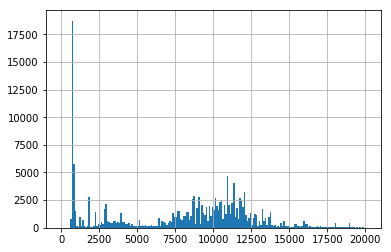

In [44]:
area = (results.x2 - results.x1) * (results.y2 - results.y1)
area.hist(bins=200, range=(0,20000))

In [45]:
# Number of predicted objects
len(results.objectid.value_counts())

2372

In [46]:
# Number of test annotations for our concepts
len(annotations[[(a in concepts) for a in annotations.conceptid]])

331

In [47]:
# Limit Results based on object max frame confidence
def conf_limit_objects(pred, threshold):
    max_conf = pd.DataFrame(pred.groupby('objectid').confidence.max())
    above_thresh = max_conf[max_conf.confidence > 0.30].index
    return pred[[(obj in above_thresh) for obj in pred.objectid]]
    

In [48]:
results = conf_limit_objects(results, 0.30)

In [49]:
# Number of predicted objects post thresholding
len(results.objectid.value_counts())

98

In [50]:
# REVISED LABEL TRANSFER USING HIGHEST SUM OF CONFIDENCES

# conf_sums = results.groupby(['objectid', 'label']).confidence.sum()
# df = conf_sums.reset_index()
# df2 = df.loc[df.groupby('objectid').label.idxmax()]
# labels = dict(zip(df2.objectid, df2.label))
# results['label'] = results.objectid.apply(lambda x: concepts[int(labels[x])])
# results['conceptid'] = results['label']


In [51]:
# REVISED LABEL TRANSFER USING HIGHEST MAXIMUM CONFIDENCE

# conf_max = results.groupby(['objectid', 'label']).confidence.max()
# df = conf_max.reset_index()
# df2 = df.loc[df.groupby('objectid').label.idxmax()]
# labels = dict(zip(df2.objectid, df2.label))
# results['label'] = results.objectid.apply(lambda x: concepts[int(labels[x])])
# results['conceptid'] = results['label']


In [52]:
# Add the majority concept id to all frames

label = None
objects = results.groupby(['objectid'])
for oid, result in objects:
    scores = {}
    # SHOULD THIS BE A WEIGHTED SUM??
    for k , label in result.groupby(['label']):
        scores[k] = label.confidence.mean() # MEAN / MAX / SUM?
    idmax = max(scores.keys(), key=(lambda k: scores[k]))
    results.loc[results.objectid == oid, 'label'] = idmax
results['label'] = results['label'].apply(lambda x: concepts[int(x)])
results['conceptid'] = results['label']

In [53]:
#results.groupby('objectid').label.value_counts()

In [54]:
# Limit results based on tracked object length ( > 30 frames)
def length_limit_objects(pred, threshold):
    obj_len = pred.groupby('objectid').conceptid.value_counts()
    len_thresh = obj_len[obj_len > threshold]
    return pred[[(obj in len_thresh) for obj in pred.objectid]] 

In [55]:
results = length_limit_objects(results, 15)

In [56]:
len(results.objectid.value_counts())

93

In [57]:
df = results.loc[results.groupby('objectid').confidence.idxmax()]

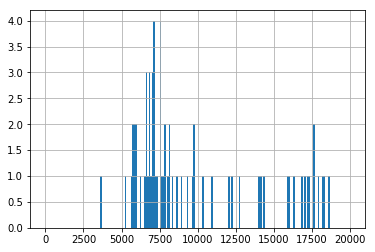

In [58]:
area = (df.x2 - df.x1) * (df.y2 - df.y1)
area.hist(bins=200, range=(0,20000))

In [59]:
# test counts
def get_counts(results, annotations):
    grouped = results.groupby(['objectid']).label.mean().reset_index()
    counts = grouped.groupby('label').count()
    counts.columns = ['pred_num']
    groundtruth_counts = pd.DataFrame(annotations.groupby('conceptid').id.count())
    groundtruth_counts.columns = ['true_num']
    return pd.concat((counts, groundtruth_counts), axis=1, join='outer').fillna(0)


In [60]:
concept_counts = get_counts(results, annotations)
concept_counts

,pred_num,true_num
236,47.0,143
237,0.0,10
383,43.0,148
812,0.0,1
1019,0.0,6
1034,0.0,24
1210,3.0,40
1399,0.0,2
3100,0.0,51
3386,0.0,1


In [61]:
def resize(row):
    new_width = 640
    new_height = 480
    x_ratio = (row.videowidth / new_width)
    y_ratio = (row.videoheight / new_height)
    row.videowidth = new_width
    row.videoheight = new_height
    row.x1 = row.x1 / x_ratio
    row.x2 = row.x2 / x_ratio
    row.y1 = row.y1 / y_ratio
    row.y2 = row.y2 / y_ratio
    return row

In [62]:
# RESIZE THE ANNOTATIONS
test_annotations = annotations.apply(resize, axis=1)

In [63]:
# pred_frames = results.frame_num.unique()
# test_frames = annotations.frame_num.unique()
# test_frames[[(val in pred_frames) for val in test_frames]]
# test_frames

In [64]:
def score_predictions(validation, predictions, iou_thresh, concepts, fps):
    
    # Maintain a set of predicted objects to verify
    detected_objects = []
    obj_map = predictions.groupby('objectid', sort=False).conceptid.max()
    
    # group predictions by video frames
    predictions = predictions.groupby('frame_num', sort=False)
    predictions = [df for _, df in predictions]
    
    # mapping frames to predictions index
    frame_data = {}
    for i, group in enumerate(predictions):
        frame_num = group.iloc[0]['frame_num']
        frame_data[frame_num] = i
    
    # group validation annotations by frames
    validation = validation.groupby('frame_num', sort=False)
    validation = [df for _, df in validation]
    
    # initialize counters for each concept
    true_positives = dict(zip(concepts,[0] * len(concepts)))
    false_positives = dict(zip(concepts,[0] * len(concepts)))
    false_negatives = dict(zip(concepts,[0] * len(concepts)))
    
    # get true and false positives for each frame of validation data
    for group in validation:
        try: # get corresponding predictions for this frame
            frame_num = group.iloc[0]['frame_num']
            predicted = predictions[frame_data[frame_num]]
        except:
            continue # False Negatives already covered
            
        detected_truths = dict(zip(concepts, [0] * len(concepts)))
        for index, truth in group.iterrows():
            for index, prediction in predicted.iterrows():
                if (prediction.conceptid == truth.conceptid
                        and compute_overlap(truth, prediction) > iou_thresh
                        and prediction.objectid not in detected_objects):
                    detected_objects.append(prediction.objectid)
                    true_positives[prediction.conceptid] += 1
                    detected_truths[prediction.conceptid] += 1
                    
        # False Negatives (Missed ground truth predicitions)
        counts = group.conceptid.value_counts()
        for concept in concepts:
            count = counts[concept] if (concept in counts.index) else 0
            false_negatives[concept] += count - detected_truths[concept]
    
    # False Positives (No ground truth prediction at any frame for that object)
    undetected_objects = set(obj_map.index) - set(detected_objects)
    for obj in undetected_objects:
        concept = obj_map[obj]
        false_positives[concept] += 1
    
    metrics = pd.DataFrame()
    for concept in concepts:
        TP = true_positives[concept]
        FP = false_positives[concept]
        FN = false_negatives[concept]
        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0
        f1 = (2*recall*precision / (precision+recall)) if (precision+recall) != 0 else 0
        metrics = metrics.append([[concept, TP, FP, FN, precision, recall, f1]])
    metrics.columns = ['conceptid', 'TP', 'FP', 'FN', 'Precision', 'Recall', 'F1']
    return metrics


In [65]:
fps = 29.97002997002997
metrics = score_predictions(test_annotations, results, 0.25, concepts, fps)


In [66]:
#metrics.set_index('conceptid')

In [67]:
metrics.set_index('conceptid').join(concept_counts)

,TP,FP,FN,Precision,Recall,F1,pred_num,true_num
conceptid,,,,,,,,
1629,0,0,0,0.000000,0.000000,0.000000,NaN,NaN
1210,1,2,12,0.333333,0.076923,0.125000,3.0,40.0
236,24,23,33,0.510638,0.421053,0.461538,47.0,143.0
383,39,4,22,0.906977,0.639344,0.750000,43.0,148.0
1133,0,0,0,0.000000,0.000000,0.000000,NaN,NaN


In [68]:
# Aim for 90% precision, at the sacrifice of 50% recall

In [69]:
# make a threshold for the bounding box size of the annotation
# for the maximum confidence annotation in each object
# maybe 10x10 pixels

In [70]:
# app.post('/api/annotations', passport.authenticate('jwt', { session: false }),
#   async (req, res) => {
#     data = [
#       req.user.id,
#       req.body.videoId,
#       req.body.conceptId,
#       req.body.timeinvideo,
#       req.body.x1,
#       req.body.y1,
#       req.body.x2,
#       req.body.y2,
#       req.body.videoWidth,
#       req.body.videoHeight,
#       req.body.image + '.png',
#       req.body.imagewithbox + '.png',
#       req.body.comment,
#       req.body.unsure
#     ];
#     const queryText = 'INSERT INTO annotations(userid, videoid,\
#                        conceptid, timeinvideo, \
#                        x1, y1, x2, y2, \
#                        videoWidth, videoHeight, \
#                        image, imagewithbox, \
#                        comment, unsure, dateannotated) \
#                        VALUES($1, $2, $3, $4, $5, $6, $7, $8, $9, $10,\
#                        $11, $12, $13, $14, current_timestamp) RETURNING *';
#     try {
#       let insertRes = await psql.query(queryText, data);
#       res.json({ message: "Annotated", value: JSON.stringify(insertRes.rows[0]) });
#     } catch (error) {
#       console.log(error)
#       res.status(400).json(error);
#     }
#   });

In [71]:
results.columns

Index(['id', 'x1', 'y1', 'x2', 'y2', 'label', 'confidence', 'objectid',
       'frame_num', 'conceptid'],
      dtype='object')

In [72]:
from dotenv import load_dotenv
import boto3

#Load environment variables
load_dotenv(dotenv_path="../.env")
AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
S3_BUCKET = os.getenv('AWS_S3_BUCKET_NAME')
s3 = boto3.client('s3', aws_access_key_id = AWS_ACCESS_KEY_ID, aws_secret_access_key = AWS_SECRET_ACCESS_KEY)
S3_VIDEO_FOLDER = os.getenv('AWS_S3_BUCKET_VIDEOS_FOLDER')


In [73]:
#dateannotated

# Uploads retina net prediciton images and puts annotation in database
def upload_prediction_image(prediction, userid, videoid, videoWidth, videoHeight, 
                            image, imagewithbox, comment, unsure, dateannotated):
    
    con = connect(database=DB_NAME, host=DB_HOST, user=DB_USER, password=DB_PASSWORD)
    cursor = con.cursor()
    
    no_box = str(annotation.videoid) + "_" + str(timeinvideo) + "_retinanet.png"
    box = str(annotation.id) + "_" + str(timeinvideo) + "_box_retinanet.png"
    temp_file = str(uuid.uuid4()) + ".png"
    
    cv2.imwrite(temp_file, frame)
    s3.upload_file(temp_file, S3_BUCKET, S3_ANNOTATION_FOLDER + no_box, ExtraArgs={'ContentType':'image/png'}) 
    os.system('rm '+ temp_file)
    cv2.imwrite(temp_file, frame_w_box)
    s3.upload_file(temp_file, S3_BUCKET, S3_ANNOTATION_FOLDER + box,  ExtraArgs={'ContentType':'image/png'})
    os.system('rm '+ temp_file)
    
    cursor.execute(
        """
        INSERT INTO annotations (
        videoid, userid, conceptid, timeinvideo, x1, y1, x2, y2, 
        videowidth, videoheight, dateannotated, image, imagewithbox, comment, unsure, originalid) 
        VALUES (%d, %d, %d, %d, %f, %f, %f, %f, %f, %d, %d, %s, %s, %s, %s, %s, %d)
        """,
        (annotation.videoid, AI_ID, annotation.conceptid, timeinvideo, x1, y1, 
        x2, y2, VIDEO_WIDTH, VIDEO_HEIGHT, datetime.datetime.now().date(), no_box, box, 
        annotation.comment, annotation.unsure, annotation.id)
    )
    con.commit()




Index(['id', 'x1', 'y1', 'x2', 'y2', 'label', 'confidence', 'objectid',
       'frame_num', 'conceptid'],
      dtype='object')

In [166]:
middle_frames = []

for obj in [df for _, df in results.groupby('objectid')]:
    middle_frame = int(obj.frame_num.median())
    frame = obj[obj.frame_num == middle_frame]
    
    if frame.shape == (0, 10):
        continue
    middle_frames.append(frame.values.tolist()[0])
    
middle_frames = pd.DataFrame(middle_frames)
middle_frames.columns = results.columns
middle_frames

,id,x1,y1,x2,y2,label,confidence,objectid,frame_num,conceptid
0,14,242.000000,265.000000,351.000000,360.000000,383,NaN,06db98fa-8b79-4b61-9f98-2e34b249fd7f,7594,383
1,161,574.000000,330.000000,646.000000,438.000000,236,NaN,0ae6daf8-0954-4b85-8c9f-68a473268cfe,18512,236
2,53,392.000000,322.000000,452.000000,370.000000,236,NaN,0c4c780f-7dbc-4544-91e4-c04aad565a50,21846,236
3,59,12.000000,208.000000,173.000000,400.000000,383,NaN,0edb53e0-a7f7-4ea0-90cb-28dfc49d0459,9349,383
4,63,375.000000,222.000000,493.000000,323.000000,236,NaN,11205754-4338-4506-b3de-79e4ac6955a1,28684,236
5,26,505.000000,208.000000,630.000000,312.000000,236,NaN,1d3deb8c-a9f6-4768-ba9d-911c1a6b751c,22166,236
6,30,0.000000,428.319489,106.117599,480.000000,383,0.105326,20dbf12c-ae2b-4fec-bec9-2d7aeacf0e06,17100,383
7,43,220.000000,225.000000,330.000000,323.000000,236,NaN,2313fc0f-8858-4772-83a3-a53e0c45099e,15934,236
8,25,536.000000,24.000000,598.000000,82.000000,236,NaN,2373331e-49a1-4020-ad6e-085fb079f8bb,19055,236
9,53,23.000000,303.000000,166.000000,424.000000,383,NaN,23effe7b-d1c7-474a-abcd-360a990963a0,17083,383


In [170]:
pd.read_csv('../../metrics86.csv')

,conceptid,TP,FP,FN,Precision,Recall,F1,pred_num,true_num
0,1629,0,0,0,0.00000,0.000000,0.000000,NaN,NaN
1,1210,1,0,18,1.00000,0.052632,0.100000,1.0,41.0
2,236,12,20,93,0.37500,0.114286,0.175182,32.0,175.0
3,383,142,40,175,0.78022,0.447950,0.569138,182.0,330.0
4,1133,0,1,1,0.00000,0.000000,0.000000,1.0,1.0
